## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mintpy.utils import readfile, writefile, utils as ut
from mintpy import view
import numpy as np
from pathlib import Path
import shutil

look at 50

In [2]:
cd /home/micromamba/data/spot/landslide_02_rangitikei

/home/micromamba/data/spot/landslide_02_rangitikei


In [3]:
rm_flag = True

In [4]:
loc = Path('mintpy')
if loc.exists():
    if rm_flag:
        shutil.rmtree(loc)
        loc.mkdir()
    else:
        pass
else:
    loc.mkdir()

In [3]:
cd mintpy

/home/micromamba/data/spot/landslide_02_rangitikei/mintpy


## Run MintPy

### Load Data

In [6]:
rm ../corrected/*xml

rm: cannot remove '../corrected/*xml': No such file or directory


In [7]:
cp /home/micromamba/scripts/autorift.cfg ./autorift.cfg

In [8]:
!load_data.py -t ./autorift.cfg

processor : cosicorr
SAR platform/sensor : unknown from project name "None"
--------------------------------------------------
prepare metadata files for cosicorr products
prep_cosicorr.py ../corrected/*NSOffset.tif --metadata ../corrected/metadata.txt
prep_cosicorr.py ../corrected/*EWOffset.tif --metadata ../corrected/metadata.txt
--------------------------------------------------
searching interferometric pairs info
input data files:
azimuthOffset   : ../corrected/*NSOffset.tif
rangeOffset     : ../corrected/*EWOffset.tif
number of azimuthOffset   : 15
number of rangeOffset     : 15
--------------------------------------------------
searching geometry files info
input data files:
--------------------------------------------------
updateMode : False
compression: None
x/ystep: 1/1
create directory: /home/micromamba/data/spot/landslide_02_rangitikei/mintpy/inputs
--------------------------------------------------
create HDF5 file /home/micromamba/data/spot/landslide_02_rangitikei/mintpy

## View stack

view.py inputs/ifgramStack.h5 azimuthOffset --vlim -25 25 --noverbose


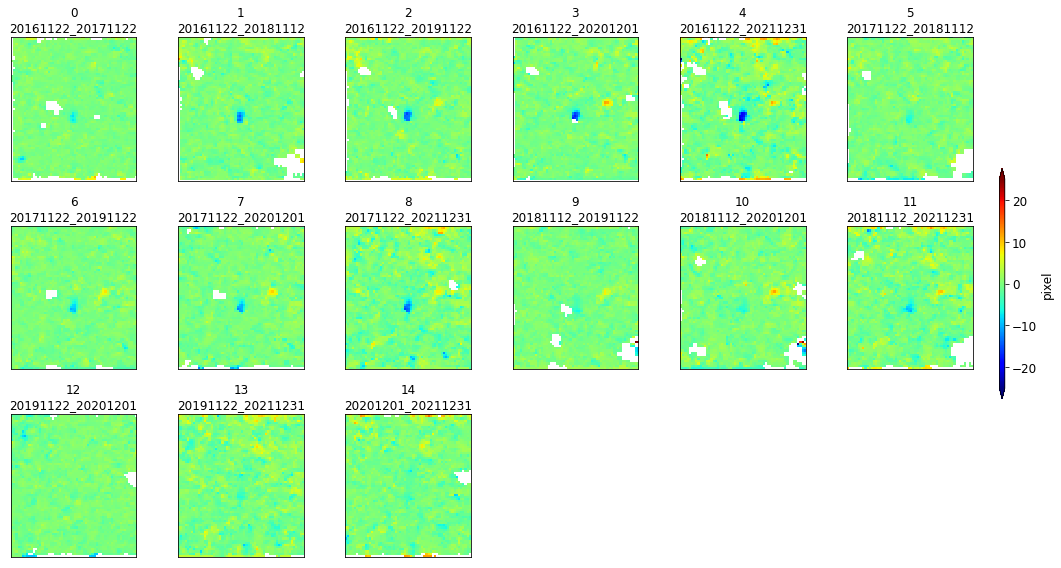

In [4]:
view.main('inputs/ifgramStack.h5 azimuthOffset --vlim -25 25 --noverbose'.split())

view.py inputs/ifgramStack.h5 rangeOffset --vlim -25 25 --noverbose


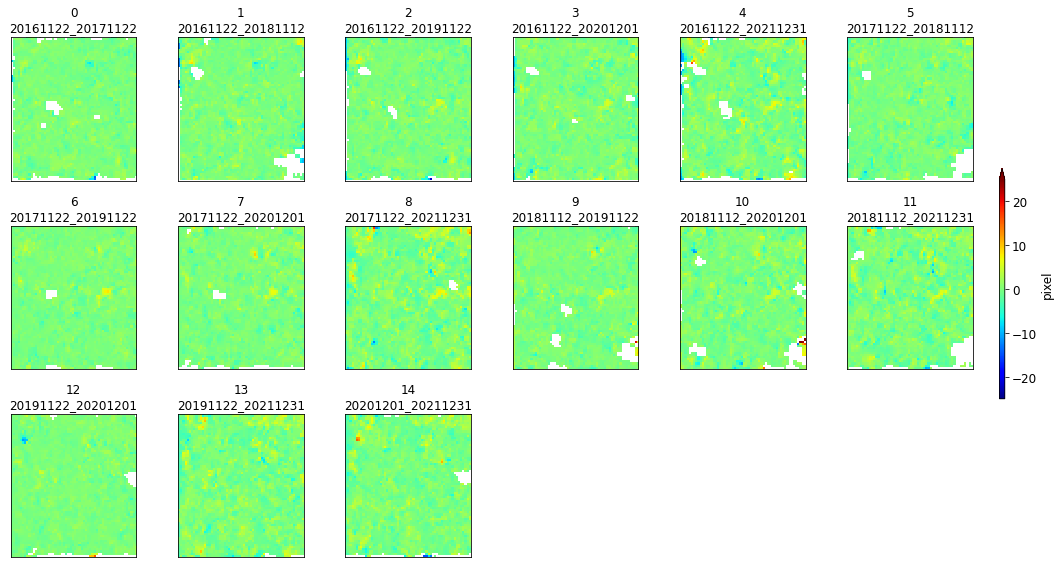

In [5]:
view.main('inputs/ifgramStack.h5 rangeOffset --vlim -25 25 --noverbose'.split())

## Inversion

In [11]:
!ifgram_inversion.py inputs/ifgramStack.h5 -i rangeOffset -w no -o timeseriesRg.h5 residualInvRg.h5 numInvOffsetRg.h5
!ifgram_inversion.py inputs/ifgramStack.h5 -i azimuthOffset -w no -o timeseriesAz.h5 residualInvAz.h5 numInvOffsetAz.h5

save the original settings of ['OMP_NUM_THREADS', 'OPENBLAS_NUM_THREADS', 'MKL_NUM_THREADS', 'NUMEXPR_NUM_THREADS', 'VECLIB_MAXIMUM_THREADS']
set OMP_NUM_THREADS = 1
set OPENBLAS_NUM_THREADS = 1
set MKL_NUM_THREADS = 1
set NUMEXPR_NUM_THREADS = 1
set VECLIB_MAXIMUM_THREADS = 1
skip checking reference pixel info - This is for offset and testing ONLY.
-------------------------------------------------------------------------------
least-squares solution with L2 min-norm on: deformation velocity
minimum redundancy: 1.0
weight function: no
calculate STD: False 
mask: no
-------------------------------------------------------------------------------
number of interferograms: 15
number of acquisitions  : 6
number of lines   : 66
number of columns : 58
--------------------------------------------------
create HDF5 file: timeseriesRg.h5 with w mode
create dataset  : date       of |S8                       in size of (6,)                 with compression = None
create dataset  : bperp      of <c

view.py timeseriesAZ.h5 --noverbose --vlim -500 500


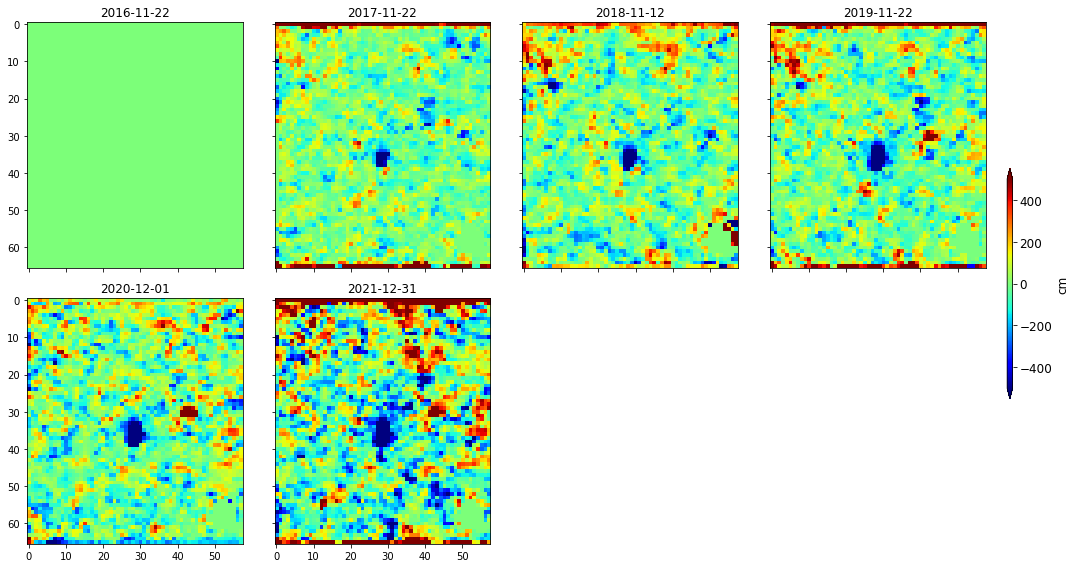

In [12]:
view.main('timeseriesAZ.h5 --noverbose --vlim -500 500'.split())

view.py timeseriesRg.h5 --noverbose --vlim -500 500


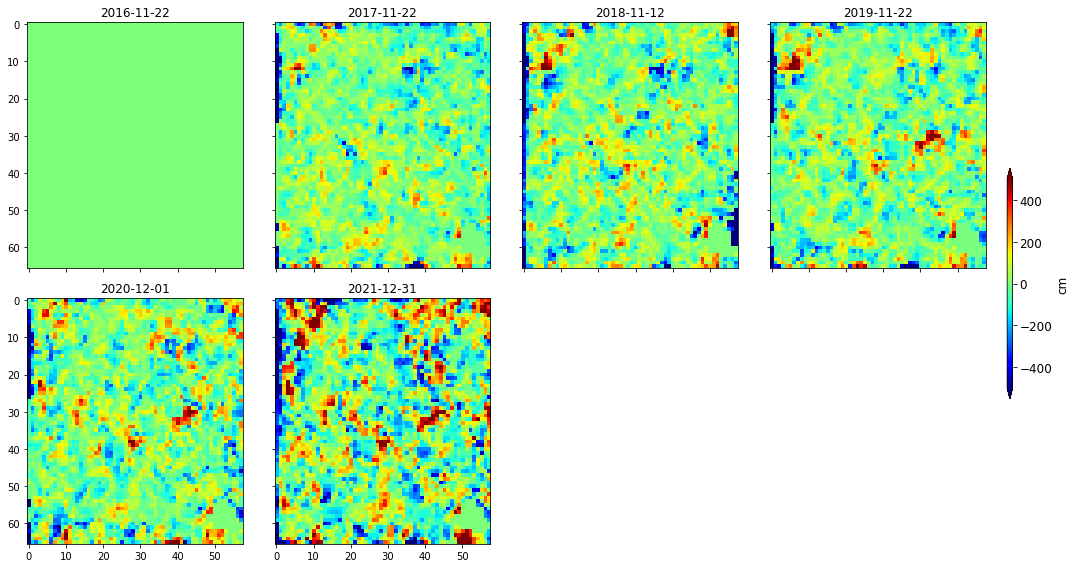

In [13]:
view.main('timeseriesRg.h5 --noverbose --vlim -500 500'.split())

## timeseries2velocity

In [16]:
!timeseries2velocity.py timeseriesAz.h5 -o velocityAz.h5
# --bootstrap --bc 100
!timeseries2velocity.py timeseriesRg.h5 -o velocityRg.h5
# --bootstrap --bc 100

open timeseries file: timeseriesAz.h5
--------------------------------------------------
dates from input file: 6
['20161122', '20171122', '20181112', '20191122', '20201201', '20211231']
--------------------------------------------------
using all dates to calculate the velocity
--------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    step       : []
    exp        : {}
    log        : {}
add/update the following configuration metadata:
['startDate', 'endDate', 'excludeDate', 'bootstrap', 'bootstrapCount']
--------------------------------------------------
create HDF5 file: velocityAz.h5 with w mode
create dataset  : velocity    of <class 'numpy.float32'>   in size of (66, 58)             with compression = None
create dataset  : velocityStd of <class 'numpy.float32'>   in size of (66, 58)             with compression = None
add /velocity    attribute: UNIT = m/year
add /velocity

## View Results

view.py velocityAz.h5 --vlim -500 500 --noverbose


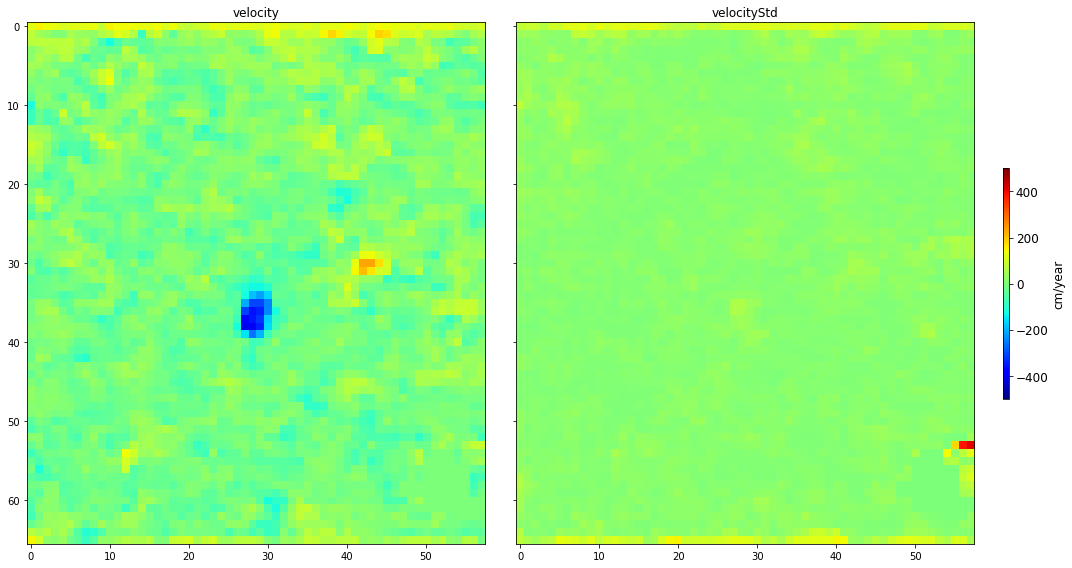

In [18]:
view.main('velocityAz.h5 --vlim -500 500 --noverbose'.split())

view.py velocityRg.h5 --vlim -500 500 --noverbose


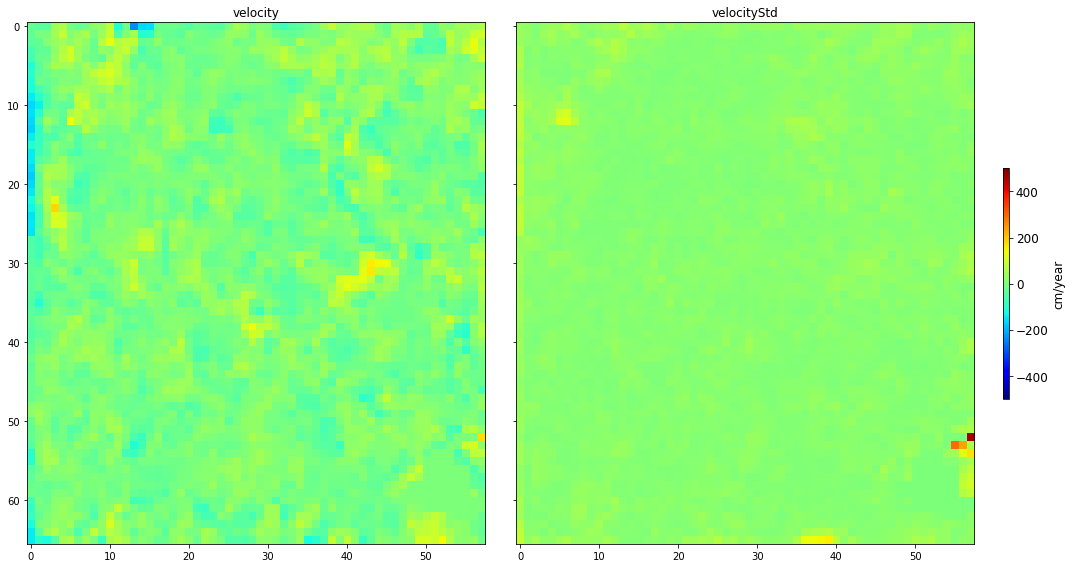

In [19]:
view.main('velocityRg.h5 --vlim -500 500 --noverbose'.split())

## Geocode

In [20]:
!save_gdal.py velocityAz.h5 -o ../velocity_sn.tif
!save_gdal.py velocityRg.h5 -o ../velocity_ew.tif

read metadata from file: velocityAz.h5
read data     from file: velocityAz.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 66, 58
raster transform info: (399405.0, 80.0, 0, 5601995.0, 0, -80.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /home/micromamba/data/spot/landslide_02_rangitikei/velocity_sn.tif
read metadata from file: velocityRg.h5
read data     from file: velocityRg.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 66, 58
raster transform info: (399405.0, 80.0, 0, 5601995.0, 0, -80.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /home/micromamba/data/spot/landslide_02_rangitikei/velocity_ew.tif


## Testing

In [10]:
from mintpy.utils import readfile

vel, atr = readfile.read('velocityAz.h5')
std, atr = readfile.read('velocityAz.h5',datasetName='velocityStd')
# print(np.nanmean(data),np.nanstd(data))

# data, atr = readfile.read('velocityRg.h5')
# print(np.nanmedian(data),np.nanstd(data))

## Done!

## Notify

In [18]:
from IPython.lib.display import Audio
import numpy as np

framerate = 4410
play_time_seconds = 2

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)